# Predicting Housing Prices in Melbourne

We'll look at a Kaggle data set of housing prices in Melbourne, Australia, and see how well we can predict in this regression problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

## Exploring the Data

In [2]:
raw_data = pd.read_csv('Melbourne_housing_FULL.csv')
print(len(raw_data))
raw_data.head()

30931


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [3]:
raw_data.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [4]:
data_clean = raw_data.drop(['Address', 'SellerG', 'Lattitude', 'Longtitude'], axis=1)

In [5]:
[print(data_clean[column].describe(), '\n') for column in data_clean.columns]

count         30931
unique          347
top       Reservoir
freq            773
Name: Suburb, dtype: object 

count    30931.000000
mean         3.019010
std          0.974469
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: Rooms, dtype: float64 

count     30931
unique        3
top           h
freq      21160
Name: Type, dtype: object 

count    2.419700e+04
mean     1.052590e+06
std      6.444995e+05
min      8.500000e+04
25%      6.350000e+05
50%      8.750000e+05
75%      1.300000e+06
max      1.120000e+07
Name: Price, dtype: float64 

count     30931
unique        9
top           S
freq      17687
Name: Method, dtype: object 

count          30931
unique            69
top       28/10/2017
freq            1119
Name: Date, dtype: object 

count    30930.000000
mean        10.971843
std          6.635226
min          0.000000
25%          6.400000
50%         10.200000
75%         13.800000
max         48.100000
Name

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
data_clean['Postcode'] = data_clean['Postcode'].apply(lambda x: str(x))
data_clean.Postcode.describe()

count      30931
unique       209
top       3073.0
freq         773
Name: Postcode, dtype: object

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


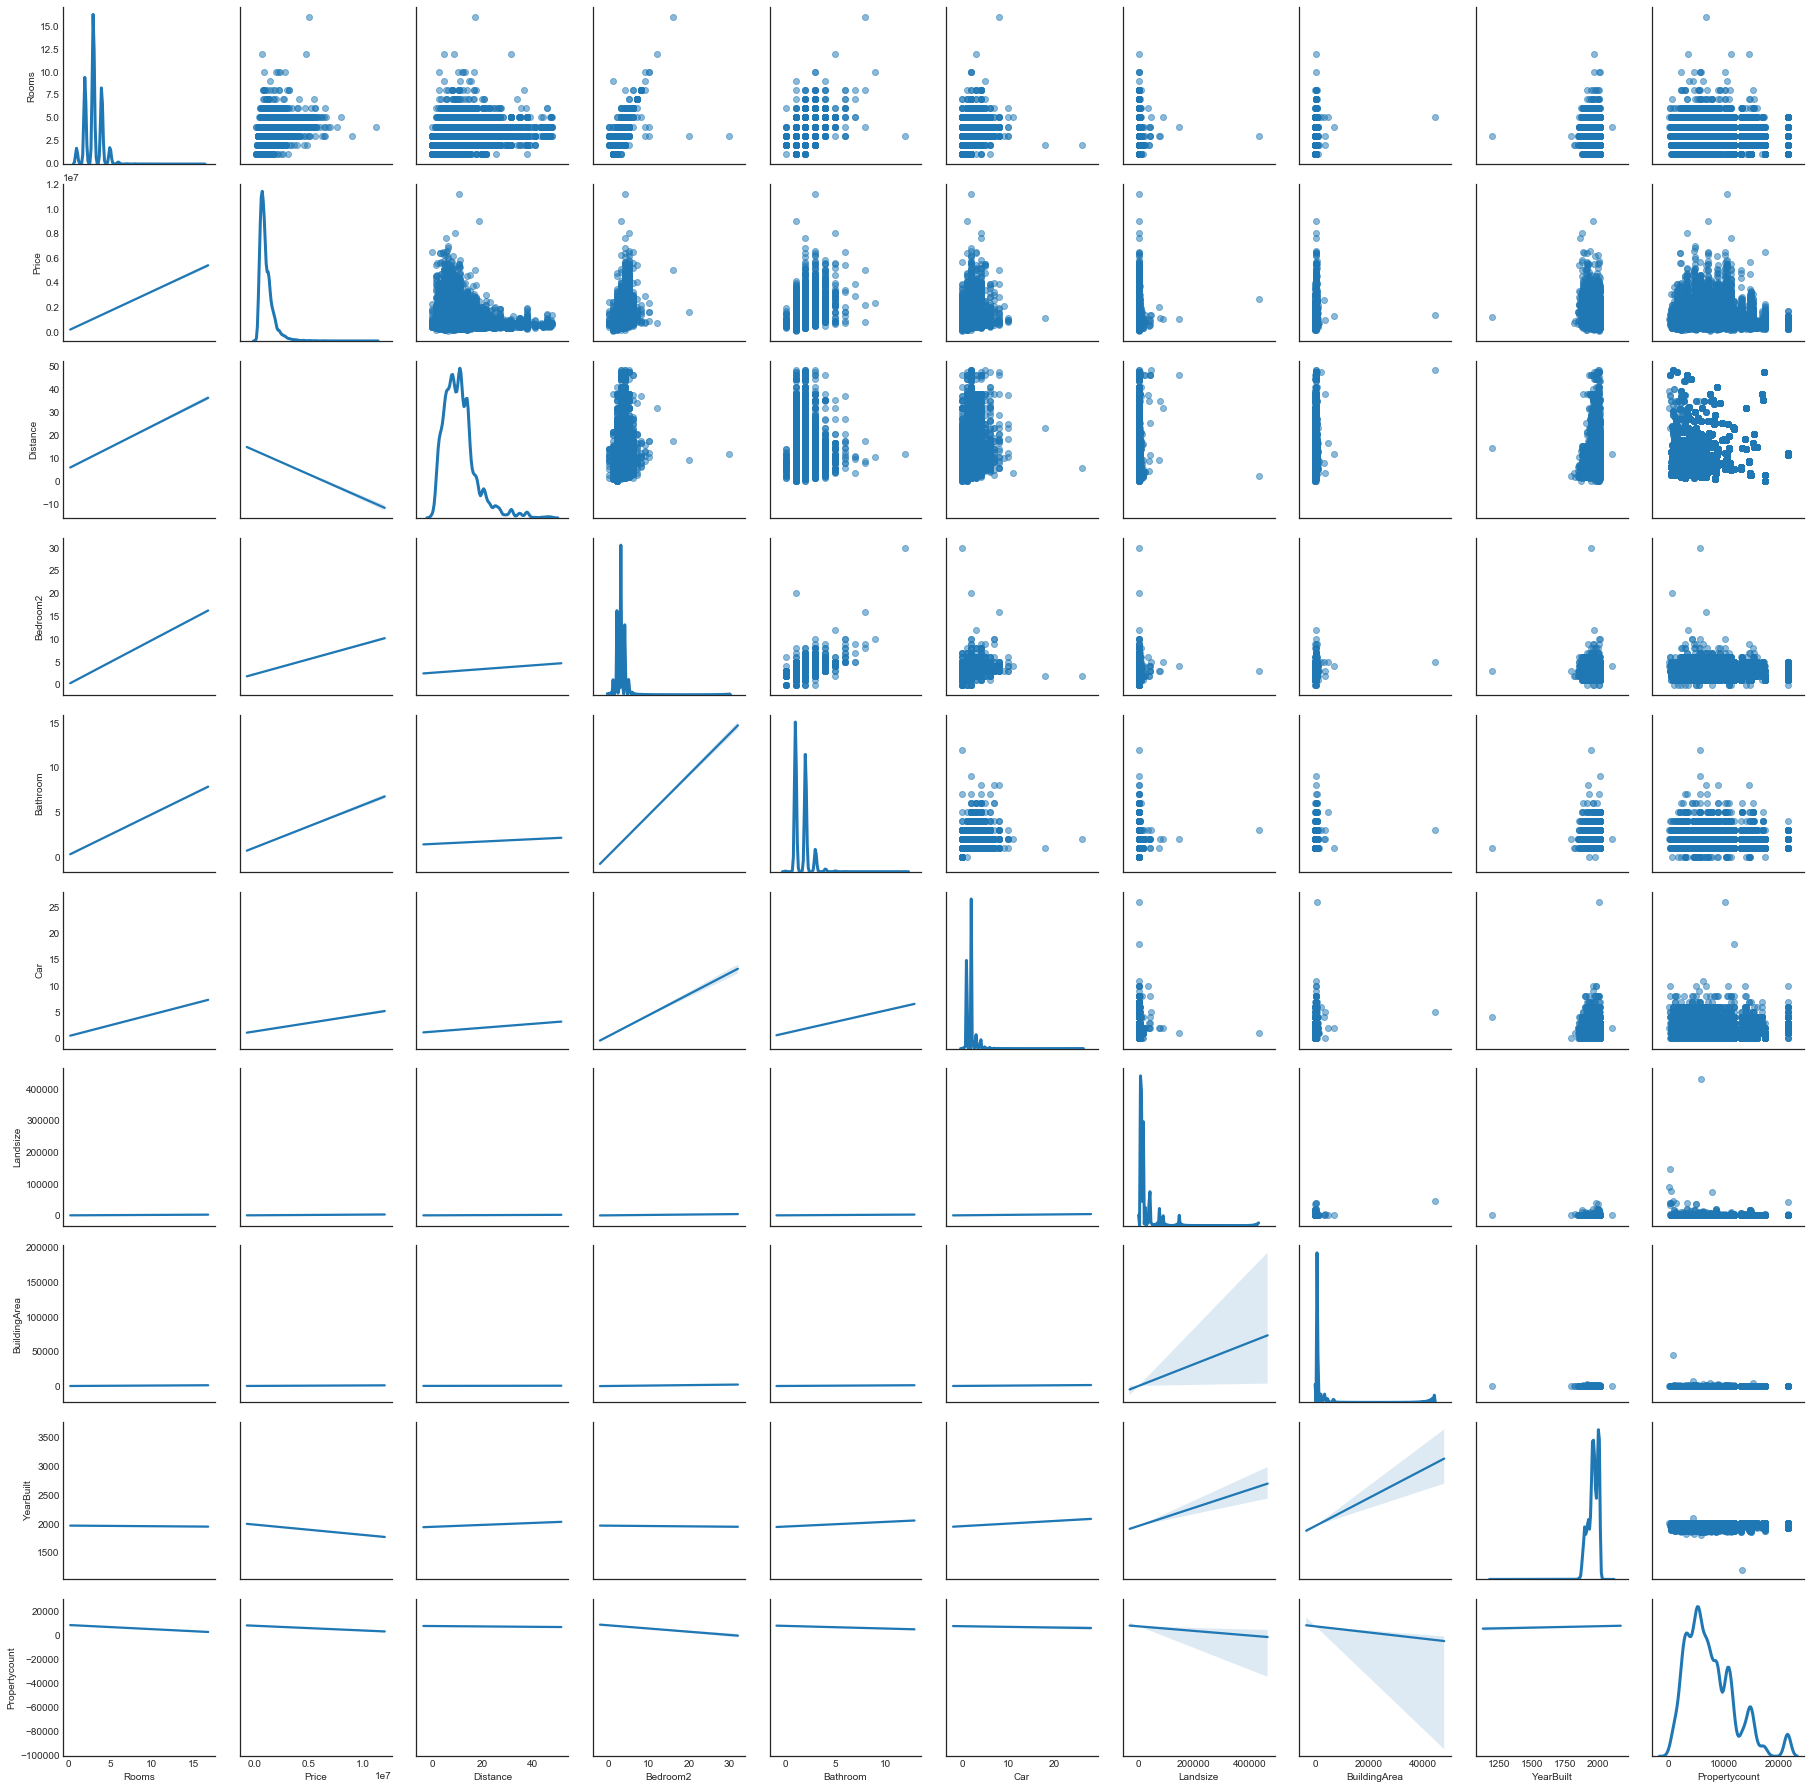

In [7]:
g = sns.PairGrid(data_clean.loc[:, ~data_clean.columns.isin(['Postcode'])], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)

plt.show()

There are a few outliers here that we'd be better off dropping or reducing to be on the same scale as the rest of the data (we'll deal with NaN's separately later). Specifically, what are these houses with enormous BuildingArea?

In [8]:
data_clean['BuildingArea'].describe()

count    12397.000000
mean       158.342861
std        418.091659
min          0.000000
25%        100.000000
50%        133.000000
75%        185.000000
max      44515.000000
Name: BuildingArea, dtype: float64

In [9]:
data_clean.drop(data_clean[data_clean['BuildingArea']>1000].index, axis=0, inplace=True)

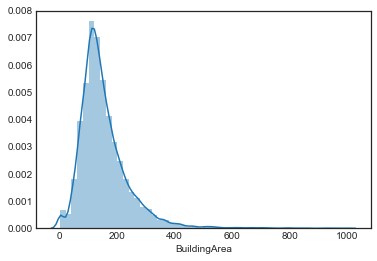

In [10]:
sns.distplot(data_clean.BuildingArea.dropna())
plt.show()

Looks much better. How about Landsize?

In [11]:
data_clean.Landsize.describe()

count     20394.000000
mean        584.722222
std        3527.578058
min           0.000000
25%         206.000000
50%         499.000000
75%         667.000000
max      433014.000000
Name: Landsize, dtype: float64

In [12]:
data_clean[data_clean.Landsize>5000]['Landsize'].count()

100

I would argue that houses with landarea > 5000 (median is 500) are an entirely different beast, and need their own pricing model. These are likely large ranches, etc, outside the city -- the largest is 433,000! Let's lose these 100 entries.

In [13]:
data_clean.drop(data_clean[data_clean.Landsize>5000].index, axis=0, inplace=True)

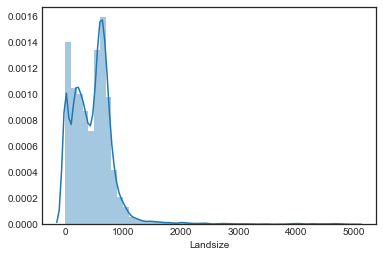

In [14]:
sns.distplot(data_clean['Landsize'].dropna())
plt.show()

That should be good for outliers at the moment. Let's run a quick model to see where we're starting from. We have a lot of categorical data (much of which is overlapping, I suspect. Suburb, Postcode, CouncilArea all sound similar). Let's see what happens if we just interpolate and one-hot encode everything.

In [16]:
data_no_mods = data_clean.interpolate().dropna()
data_no_mods = pd.get_dummies(data_no_mods)

data_no_mods.shape

(30814, 681)

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.utils import resample
from sklearn.preprocessing import Imputer

In [18]:
data_train, data_test = train_test_split(data_no_mods, test_size=0.3)
X_train = data_train.loc[:, ~data_train.columns.isin(['Price'])]
X_test = data_test.loc[:, ~data_test.columns.isin(['Price'])]
Y_train = data_train['Price']
Y_test = data_test['Price']

In [19]:
rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train, Y_train)
rfr.score(X_test, Y_test)

0.55126612543536158

Hey, that's not half bad for a starting point. Let's see how much better we can do.

## Data Cleaning

First of all, we interpolated all the variables, including Price. We should drop the NaN price values rather than interpolating them.

In [20]:
data_clean = data_clean.dropna(subset=['Price'])
data_clean.shape

(24110, 17)

Aside from that, we'll have to decide how to treat the rest of the NaNs in the dataset. We could interpolate, or we could drop them, even though we'll only be left with 8,000 examples. Let's see how interpolating and dropping compare and decide based on that. We could also get into some of the different types of sklearn.preprocessing.impute.

In [21]:
# Here we interpolate

data_int = data_clean.interpolate().dropna()
data_int = pd.get_dummies(data_int)

data_train_int, data_test_int = train_test_split(data_int, test_size=0.3)
X_train_int = data_train_int.loc[:, ~data_train_int.columns.isin(['Price'])]
X_test_int = data_test_int.loc[:, ~data_test_int.columns.isin(['Price'])]
Y_train_int = data_train_int['Price']
Y_test_int = data_test_int['Price']

# And here we drop.

data_drop = data_clean.dropna()
data_drop = pd.get_dummies(data_drop)

data_train_drop, data_test_drop = train_test_split(data_drop, test_size=0.3)
X_train_drop = data_train_drop.loc[:, ~data_train_drop.columns.isin(['Price'])]
X_test_drop = data_test_drop.loc[:, ~data_train_drop.columns.isin(['Price'])]
Y_train_drop = data_train_drop['Price']
Y_test_drop = data_test_drop['Price']

print('Shapes of Interpolation set and Dropped set:')
print(data_int.shape, data_drop.shape)

Shapes of Interpolation set and Dropped set:
(24106, 671) (7945, 628)


In [22]:
rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train_int, Y_train_int)
print('Score with interpolation:')
print(rfr.score(X_test_int, Y_test_int))

rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train_drop, Y_train_drop)
print('\nScore dropping NaN:')
print(rfr.score(X_test_drop, Y_test_drop))

Score with interpolation:
0.762053288891

Score dropping NaN:
0.826080360545


Okay, this is interesting -- we're doing noticeably better with the smaller dataset with dropped NaNs than with interpolated values. Let's take a closer look at which columns are the worst offenders for NaN.

In [23]:
data_clean.isnull().sum()

Suburb               0
Rooms                0
Type                 0
Price                0
Method               0
Date                 0
Distance             1
Postcode             0
Bedroom2          5524
Bathroom          5528
Car               5798
Landsize          8251
BuildingArea     14550
YearBuilt        13201
CouncilArea          3
Regionname           3
Propertycount        3
dtype: int64

BuildingArea and YearBuilt are particularly bad, while Bedroom2, Bathroom, Car, and Landsize are less bad. After some messing around, it appears that we do the best when we impute (using 'mean') on all those columns, even though they're missing so much data. We'll dropna() at the end to get rid of those few stray NaNs in other columns.

In [24]:
impute = Imputer(strategy='mean')

data_imputed = data_clean.copy()
data_imputed[['Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']] = impute.fit_transform(data_imputed[['Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']])

data_imputed.dropna(inplace=True)
data_imputed = pd.get_dummies(data_imputed)
data_imputed.shape

(24107, 671)

In [25]:
data_train, data_test = train_test_split(data_imputed, test_size=0.3)
X_train = data_train.loc[:, ~data_train.columns.isin(['Price'])]
X_test = data_test.loc[:, ~data_test.columns.isin(['Price'])]
Y_train = data_train['Price']
Y_test = data_test['Price']

In [26]:
rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train, Y_train)
print(rfr.score(X_test, Y_test))

0.762938908443


We are still a couple percentage points off the score we got for dropping all the rows with missing data, but this is a lot more true to the data set. After all, with the smaller set, we're restricted to only predicting housing values that contain ALL the data. This way we're more flexible.

So what about the question of whether we should one-hot encode all the categorical data? It does blow up our data set a bit, but I think we're better off capturing all that information and paring it down with feature selection if necessary than throwing it out ahead of time. So let's keep our pd.get_dummies method in there and work from here.

So what's next?

## Feature Selection

We'll take a look at results from Select K Best, PCA, RFE, and Random Forest feature importances. First, Random Forest so we have a sense of how many features we'll need to keep.

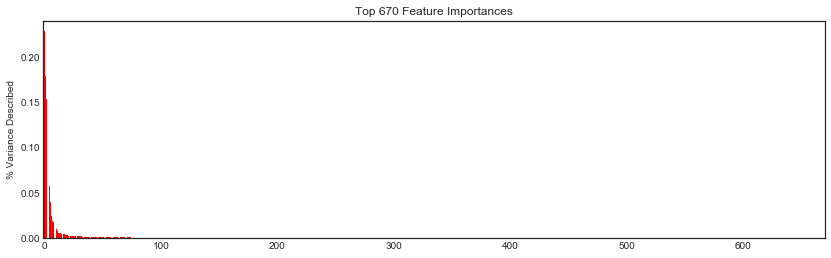

In [27]:
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:1000]

# Plot the feature importances of the forest
plt.figure(figsize=(14, 4))
plt.title("Top {} Feature Importances".format(len(top_indices)))
plt.bar(range(len(top_indices)), importances[top_indices],
       color="r", align="center")
plt.xlim([-1, len(top_indices)])
plt.ylabel('% Variance Described')
plt.show()

In [28]:
for n_idx in [10, 20, 50, 100, 200, 300, 500]:
    print('Variance explained with {} features: {}'.format(n_idx, importances[indices[:n_idx]].sum()))
print('Total Features: ' + str(len(indices)))

Variance explained with 10 features: 0.799075020031626
Variance explained with 20 features: 0.8569728872352689
Variance explained with 50 features: 0.9185391598015937
Variance explained with 100 features: 0.9644619343189267
Variance explained with 200 features: 0.9919263476618226
Variance explained with 300 features: 0.9972198710374155
Variance explained with 500 features: 0.999847157162815
Total Features: 670


Our feature importance drops off sharply, so we can safely keep fewer features. Let's stick with the top 100 for now, which allows us to capture 96% of the variance in the data set.

In [29]:
n_indices = 100
X_train_rfr = X_train.loc[:, X_train.columns[indices[:n_indices]]]
X_test_rfr = X_test.loc[:, X_train.columns[indices[:n_indices]]]
print(X_train_rfr.shape, X_test_rfr.shape)

(16874, 100) (7233, 100)


In [30]:
skb = SelectKBest(k=100)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 94  99 222 270 314 328 548 610 614] are constant.
  UserWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [31]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=100)
rfe.fit(X_train, Y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [32]:
pca = PCA(n_components=100)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Let's see how these engineered data sets compare to each other, and to our full feature set.

In [137]:
rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train, Y_train)
print('Full feature set:')
print(rfr.score(X_test, Y_test))

rfr.fit(X_train_rfr, Y_train)
print('\nRFR Feature Importances:')
print(rfr.score(X_test_rfr, Y_test))

rfr.fit(X_train_skb, Y_train)
print('\nSelect K Best:')
print(rfr.score(X_test_skb, Y_test))

rfr.fit(X_train_rfe, Y_train)
print('\nRFE:')
print(rfr.score(X_test_rfe, Y_test))

rfr.fit(X_train_pca, Y_train)
print('\nPCA:')
print(rfr.score(X_test_pca, Y_test))

Full feature set:
0.765579749619

RFR Feature Importances:
0.749641548782

Select K Best:
0.609560694551

RFE:
0.756237069809

PCA:
0.715604165179


It looks like we can do almost as well with our RFE feature selection as with our full feature set -- let's tune our initial models using that smaller feature set, and then choose the best to run with the full set of features.

## Model Tuning

Let's try: Linear Regression, Ridge Regression, Lasso Regression, KNeighbors, Decision Tree (with gridsearch), Random Forest (with gridsearch), Gradient Boosting (with gridsearch), and SVM.

In [144]:
lnr = LinearRegression(fit_intercept=True, normalize=False)
lnr.fit(X_train_rfe, Y_train)
print(lnr.score(X_test_rfe, Y_test))

0.632477481939


In [152]:
rid = Ridge(alpha=1)
rid.fit(X_train_rfe, Y_train)
print(rid.score(X_test_rfe, Y_test))

0.632484174479


In [158]:
las = Lasso(alpha=1)
las.fit(X_train_rfe, Y_train)
print(las.score(X_test_rfe, Y_test))

0.632479621605


In [167]:
knr = KNeighborsRegressor(n_neighbors=5)
knr.fit(X_train_rfe, Y_train)
print(knr.score(X_test_rfe, Y_test))

0.550870083641


In [168]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_rfe, Y_train)
print(dtr.score(X_test_rfe, Y_test))

0.556305749487


In [171]:
dtr_params = {'max_depth':[12, 32, None],
              'max_features':[2, 8, 32, None],
              'min_samples_split':[2, 4, 8]}
dtr_grid = GridSearchCV(DecisionTreeRegressor(), param_grid=dtr_params)
dtr_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [12, 32, None], 'max_features': [2, 8, 32, None], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [172]:
print(dtr_grid.best_score_)
print(dtr_grid.best_params_)

0.640912062392
{'max_depth': 12, 'max_features': None, 'min_samples_split': 8}


In [173]:
rfr = RandomForestRegressor()
rfr.fit(X_train_rfe, Y_train)
print(rfr.score(X_test_rfe, Y_test))

0.732812580905


In [181]:
rfr_params = {'max_depth':[32, None],
              'n_estimators':[8, 64],
              'min_samples_split':[2, 8]}
rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid=rfr_params)
rfr_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [32, None], 'n_estimators': [8, 64], 'min_samples_split': [2, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [175]:
print(rfr_grid.best_score_)
print(rfr_grid.best_params_)

0.744171264593
{'max_depth': 32, 'min_samples_split': 8, 'n_estimators': 64}


In [176]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train_rfe, Y_train)
print(gbr.score(X_test_rfe, Y_test))

0.733064503557


In [180]:
gbr_params = {'max_depth':[12, 32],
              'n_estimators':[50, 100],
              'learning_rate':[0.1, 0.3]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(), param_grid=gbr_params)
gbr_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [12, 32], 'n_estimators': [50, 100], 'learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [179]:
print(gbr_grid.best_score_)
print(gbr_grid.best_params_)

0.736026330808
{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100}


In [33]:
svr = SVR()
svr.fit(X_train_rfe, Y_train)
print(svr.score(X_test_rfe, Y_test))

-0.0741845823393


## Best Model and Cross Validation

It turns out random forest still gives us the best outcome on the test set. Let's run the model with the optimized parameters on the full feature set, and include cross validation.

In [34]:
rfr = RandomForestRegressor(max_depth=32, min_samples_split=8, n_estimators=64)
rfr.fit(X_train, Y_train)
print(cross_val_score(rfr, X_train, Y_train, cv=5))
print(rfr.score(X_test, Y_test))

[ 0.77483632  0.76740323  0.76000404  0.73933462  0.73523543]
0.766206738711


Let's take a look at some of what we got wrong.

In [35]:
Y_pred = rfr.predict(X_test)

In [36]:
residuals = Y_test - Y_pred

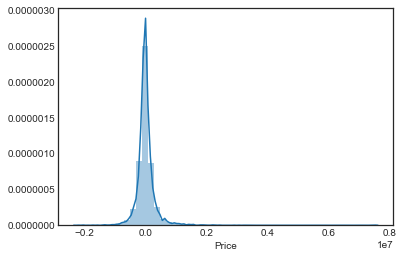

In [38]:
sns.distplot(residuals)
plt.show()

Our residuals are mostly symmetrical, which is good, and fairly normally distributed, aside from a handful of bad guesses to the right. Let's see if there's anything noticeable about those "way off" examples.

In [104]:
bad_guesses = residuals.sort_index().where(residuals>2000000).dropna().index.tolist()

In [105]:
data_clean.loc[bad_guesses, data_clean.columns]

,Suburb,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount
5180,Hawthorn,3,h,5100000.0,S,3/12/2016,4.6,3122.0,3.0,2.0,3.0,1038.0,NaN,NaN,Boroondara City Council,Southern Metropolitan,11308.0
6391,Malvern East,5,h,4802500.0,S,10/12/2016,11.2,3145.0,5.0,2.0,4.0,837.0,267.0,1919.0,Stonnington City Council,Southern Metropolitan,8801.0
7405,Northcote,5,h,4300000.0,SP,24/09/2016,5.5,3070.0,4.0,4.0,3.0,569.0,NaN,1910.0,Darebin City Council,Northern Metropolitan,11364.0
11001,Aberfeldie,4,h,3900000.0,S,10/12/2016,9.1,3040.0,4.0,4.0,4.0,670.0,375.0,2010.0,Moonee Valley City Council,Western Metropolitan,1543.0
12578,Caulfield North,1,u,3050000.0,SP,6/05/2017,8.1,3161.0,NaN,NaN,NaN,NaN,NaN,NaN,Glen Eira City Council,Southern Metropolitan,6923.0
15029,Hawthorn,5,h,5510000.0,S,3/06/2017,5.3,3122.0,5.0,2.0,5.0,820.0,300.0,1971.0,Boroondara City Council,Southern Metropolitan,11308.0
15098,Malvern,3,h,4900000.0,VB,3/06/2017,5.9,3144.0,3.0,4.0,2.0,950.0,NaN,NaN,Stonnington City Council,Southern Metropolitan,4675.0
15696,Hawthorn,4,h,7650000.0,S,17/06/2017,5.3,3122.0,4.0,2.0,4.0,1690.0,284.0,1863.0,Boroondara City Council,Southern Metropolitan,11308.0
23154,Glen Iris,5,h,5770000.0,S,26/08/2017,7.3,3146.0,5.0,3.0,2.0,NaN,638.0,2011.0,Boroondara City Council,Southern Metropolitan,10412.0
25635,Brighton,4,h,11200000.0,VB,28/10/2017,10.5,3186.0,4.0,3.0,2.0,1400.0,NaN,NaN,Bayside City Council,Southern Metropolitan,10579.0


They're all expensive, which may be a sign that our model can't really figure out what makes a nice house into a REALLY nice house. Many are missing data, and they all seem to be in 3-4 unique Council Districts. Perhaps something about those districts makes the houses hard to predict. Let's look at our residual curve without the outliers to get a better sense of its shape.

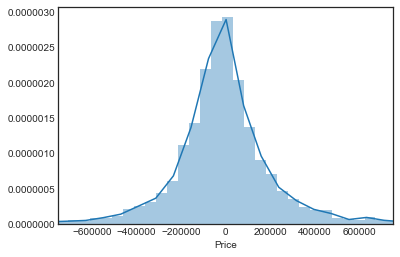

In [109]:
sns.distplot(residuals, bins=200)
plt.xlim([-750000, 750000])
plt.show()

It's actually a bit sharper than the Gaussian distribution. 

All in all, it seems like a score of 0.77 is pretty decent for a first shot at predicting housing prices!